In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
import riskfolio.Portfolio as pf


import empyrical.stats as em
import quantstats as qs
import pyfolio as pyf
%matplotlib inline

import time

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import plotly.graph_objects as go
from dash.dependencies import Input, Output, State


#Added by Ji Wu
plt.style.use('fivethirtyeight')
np.random.seed(777)


import warnings
warnings.filterwarnings("ignore")

yf.pdr_override()
# pd.options.display.float_format = '{:.4%}'.format


C:\Users\titas\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\titas\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
# Date range
start =  '2000-01-03'  #POS'2000-01-03' #2001-01-11 
end =   '2017-12-31' #POS'2017-01-31' #'2018-01-02' 


# Tickers of stocks - Inputted from dashboard
stocks = ['BAC', 'C', 'SNV', 'STI', 'WFC', 'LNC', 'PGR', 'GL', 'GS',
                  'SCHW', 'AXP', 'BEN', 'BLK', 'COF', 'MS']
stocks.sort()


#With SPY
assets = stocks.copy()
assets.append('SPY')

   
# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets


# Calculating returns
Return_Data = data.pct_change().dropna()
# Return_Data.head()

[*********************100%***********************]  16 of 16 completed


In [3]:
window = 1500
num_portfolios = 2000
month = 22

In [4]:
#Function to calculate COSR weights
def CoSR_weights(i,c, tickers):
    index = i
    port_CoSR_ratio = []
    port_volatility = []
    stock_weights = []
    weights = []
    stocks = tickers

#     df = Return_Data[i:i+window]
    
    df_return_C = pd.DataFrame(columns = assets)
    df = Return_Data[i:i+window].iloc[4:]
    
    a = 0
    while a < len(df):
        if qs.stats.comp(df[a:a+month]['SPY']) < c:
            df_return_C = df_return_C.append(df[a:a+month])
        a= a+month

    #Filtering based on ticker_list
    ticker_spy = tickers.copy()
    ticker_spy.append('SPY')
#     df = df[ticker_spy] 
    
#     Y_SPY = pd.DataFrame(df[df['SPY']< c]['SPY'])
#     Y = df[df['SPY']< c][stocks] 
    df  = df_return_C[ticker_spy]
    Y_SPY = pd.DataFrame(df['SPY'], columns = ['SPY'])
    Y = df[stocks] 
    
    
    cov_matrix = Y.cov()
    mean_returns = Y.mean()
    mkt_returns = Y_SPY.SPY.mean()

    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        mkt_returns = df['SPY'].mean()
        returns = np.dot(weights, mean_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        CoSR_ratio = (returns - mkt_returns)/volatility
        port_CoSR_ratio.append(CoSR_ratio)
        stock_weights.append(weights)
        
    weight = stock_weights[port_CoSR_ratio.index(max(port_CoSR_ratio))]

    df = pd.DataFrame(data = weight, index = stocks).T
  
    #print(index+window+month + 1 )
    #print(len(data)-(index+window+1))
    if index+window+month + 1 < len(data):
        newdf = pd.DataFrame(np.repeat(df.values,month,axis=0))
        newdf.columns = df.columns
        newdf['Date'] = data.index.values[index+window+1:index+window+month + 1]
    else:
        newdf = pd.DataFrame(np.repeat(df.values,len(data)-(index+window+1),axis=0))
        newdf.columns = df.columns
        newdf['Date'] = data.index.values[index+window+1:len(data)]
    
    newdf= newdf.set_index('Date')
    return newdf

In [5]:
#Function to calculate SR weights
def SR(index, tickers):

    #Slicing the data
    Y = Return_Data[index:index+window].drop(columns=['SPY'])

    #Filtering based on ticker_list
    Y = Y[tickers]
     
    # Building the portfolio object
    port = pf.Portfolio(returns=Y)
    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Configuring short weights options

#     port.sht = True # Allows to use Short Weights
#     port.uppersht = 0.3 # Maximum value of sum of short weights in absolute value

    # Estimate optimal portfolio:

    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = 'MV' # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    df = w.T
     
 
    if index+window+month + 1 < len(data):
        newdf = pd.DataFrame(np.repeat(df.values,month,axis=0))
        newdf.columns = df.columns
        newdf['Date'] = data.index.values[index+window+1:index+window+month + 1]
    else:
        newdf = pd.DataFrame(np.repeat(df.values,len(data)-(index+window+1),axis=0))
        newdf.columns = df.columns
        newdf['Date'] = data.index.values[index+window+1:len(data)]
    
    newdf= newdf.set_index('Date')
        
    return newdf

In [6]:
#Function to calculate weights for each portfolio
def weights(tickers):
    #Computing weights based on COSR/ SR/ 1/n
    df_CoSRweights = pd.DataFrame(columns = tickers)
    df_SR_weights = pd.DataFrame(columns = tickers)

    #Set the value of C
#     c = -0.067
    c = 0.0

    i = 0
    while i <= len(Return_Data.index.values)-window:
#         print (i)
        weight_CoSR = CoSR_weights(i,c, tickers) 
        df_CoSRweights= df_CoSRweights.append(weight_CoSR)
#         tickers = tickers.drop(columns=['SPY'])
        weight_SR = SR(i,tickers)
        df_SR_weights= df_SR_weights.append(weight_SR)
        i = i + month
    return df_CoSRweights, df_SR_weights

In [7]:
def return_metrics (tickers):
    #Individual returns over the period
    i_returns = Return_Data[1500:len(data)].drop(columns=['SPY'])
    i_returns = i_returns[tickers]

    #Calling the weights function

    df_CoSRweights, df_SR_weights = weights(tickers)

    #Computing SR & equally weighted portfolio returns portfolio returns
    p_cosr_returns = df_CoSRweights[tickers[0]]*i_returns[tickers[0]]
    p_sr_returns = df_SR_weights[tickers[0]]*i_returns[tickers[0]]
    p_ew_returns = (1/len(tickers))*i_returns[tickers[0]]
    i=1
    while i < len(tickers):
        p_cosr_returns = p_cosr_returns + df_CoSRweights[tickers[i]]*i_returns[tickers[i]]
        p_sr_returns = p_sr_returns + df_SR_weights[tickers[i]]*i_returns[tickers[i]]
        p_ew_returns = p_ew_returns + (1/len(tickers))*i_returns[tickers[i]]
        i = i + 1
        
    #Return-Cumulative returns Dataframe    
    df_return = pd.DataFrame({'COSR_Returns': p_cosr_returns, 'SR_Returns': p_sr_returns,
                   'EW_Returns': p_ew_returns, 'Cum_COSR_Returns': p_cosr_returns.add(1).cumprod(),
                   'Cum_SR_Returns': p_sr_returns.add(1).cumprod(),'Cum_EW_Returns': p_ew_returns.add(1).cumprod(),
                  })     
        
    #Calculatig metrics    
    df_metrics = pd.DataFrame(columns=['metric','p_cosr_returns', 'p_sr_returns', 'p_ew_returns'])
    metrics= [f for f in dir(qs.stats) if f[0] != '_']
    for i in range(0,len(metrics)):
        if metrics[i] not in ['compare', 'consecutive_losses', 'consecutive_wins', 'greeks', 'information_ratio', 
                              'pct_rank', 'r2', 'r_squared', 'rolling_greeks']:
            metric = metrics[i]
            cosr = eval('qs.stats.'+metrics[i]+'(p_cosr_returns)')
            sr = eval('qs.stats.'+metrics[i]+'(p_sr_returns)')
            ew = eval('qs.stats.'+metrics[i]+'(p_ew_returns)')
            df_metrics = df_metrics.append({'metric':metric, 'p_cosr_returns':cosr, 'p_sr_returns':sr, 'p_ew_returns':ew}, ignore_index=True)

    df_metrics= df_metrics.set_index('metric')
    
    
    return df_CoSRweights, df_SR_weights, df_return, df_metrics 

In [8]:
ticker_list = ['BAC', 'C', 'SNV', 'STI', 'WFC', 'LNC', 'PGR', 'GL', 'GS',
                  'SCHW', 'AXP', 'BEN', 'BLK', 'COF']
startd = time.time()
print(startd)
df_CoSRweights, df_SR_weights, df_return, df_metrics  = return_metrics(ticker_list)
endd = time.time()
print(endd - startd)

1598757544.1846097
980.5486686229706


In [9]:
display(df_CoSRweights.head())
display(df_CoSRweights.head()) 
display(df_return.head())
display(df_metrics)

,BAC,C,SNV,STI,WFC,LNC,PGR,GL,GS,SCHW,AXP,BEN,BLK,COF
2005-12-20,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-21,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-22,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-23,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-27,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206


,BAC,C,SNV,STI,WFC,LNC,PGR,GL,GS,SCHW,AXP,BEN,BLK,COF
2005-12-20,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-21,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-22,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-23,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206
2005-12-27,0.101564,0.015814,0.159002,0.089449,0.020516,0.052801,0.146598,0.099094,0.05022,0.006803,0.025644,0.02605,0.170237,0.036206


,COSR_Returns,SR_Returns,EW_Returns,Cum_COSR_Returns,Cum_SR_Returns,Cum_EW_Returns
2005-12-20,-0.000459,-0.003017,0.003896,0.999541,0.996983,1.003896
2005-12-21,-0.008056,-0.012428,-0.000823,0.991489,0.984592,1.003070
2005-12-22,0.005124,0.005993,0.004352,0.996570,0.990493,1.007435
2005-12-23,0.003274,0.002607,0.002233,0.999833,0.993075,1.009685
2005-12-27,-0.006373,-0.006498,-0.009282,0.993461,0.986622,1.000313


,p_cosr_returns,p_sr_returns,p_ew_returns
metric,,,
avg_loss,-0.0117567,-0.0124849,-0.0129922
avg_return,0.000440684,0.000512077,0.000551851
avg_win,0.0111834,0.0120965,0.0127525
best,0.158275,0.190791,0.176423
cagr,0.0697631,0.0822216,0.0850317
calmar,0.096368,0.131489,0.110615
common_sense_ratio,0.991779,1.03889,1.01748
comp,1.2512,1.58775,1.66977
compsum,2005-12-20 -0.000459 2005-12-21 -0.008511 ...,2005-12-20 -0.003017 2005-12-21 -0.015408 ...,Date 2005-12-20 0.003896 2005-12-21 0.00...


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2005-12-20  2005-12-20
End Period                 2017-12-29  2017-12-29
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          125.12%     166.98%
CAGR%                      6.98%       8.5%
Sharpe                     0.38        0.41
Sortino                    0.54        0.6
Max Drawdown               -72.39%     -76.87%
Longest DD Days            2122        2165
Volatility (ann.)          29.53%      33.9%
R^2                        0.96        0.96
Calmar                     0.1         0.11
Skew                       0.32        0.35
Kurtosis                   12.08       13.36

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.56%       0.68%
Expected Yearly %          6.44%       7.85%
Kelly Criterion            4.0%        3.38%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-10,2009-03-09,2013-08-01,2122,-72.392464,-65.443783
2,2015-07-20,2016-02-11,2016-11-10,479,-22.616432,-20.414937
3,2007-07-16,2007-08-15,2007-10-09,85,-14.227169,-13.366538
4,2014-01-02,2014-02-03,2014-06-06,155,-9.329843,-8.410261
5,2006-05-08,2006-06-14,2006-09-25,140,-9.317367,-8.811232


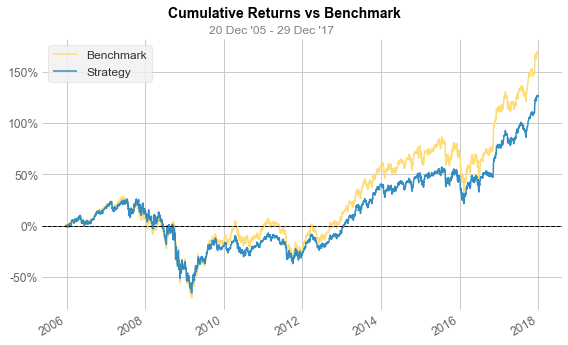

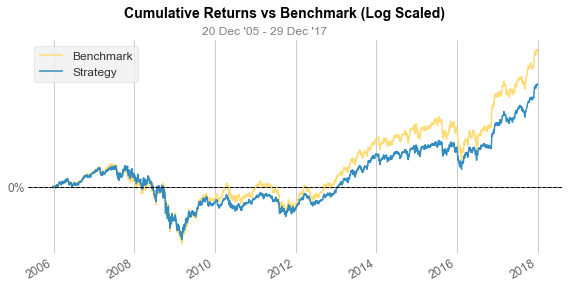

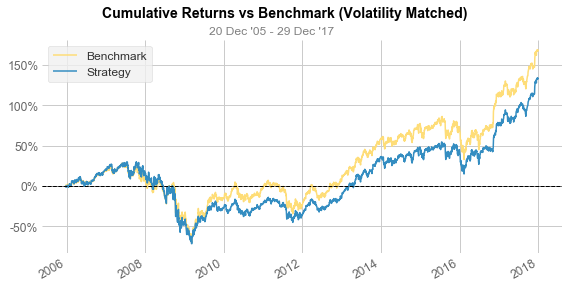

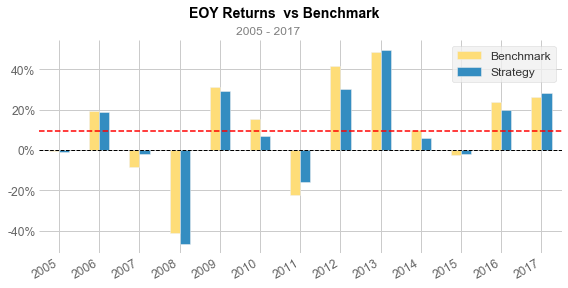

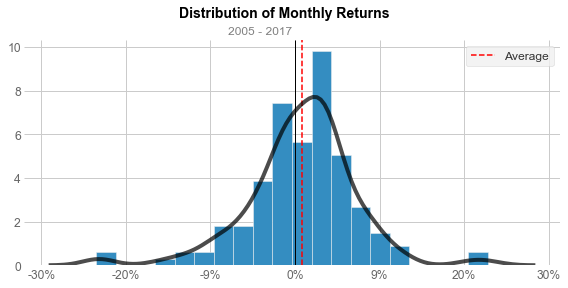

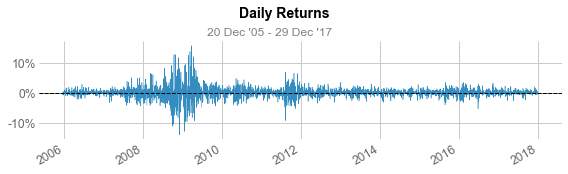

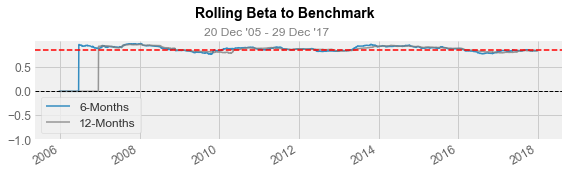

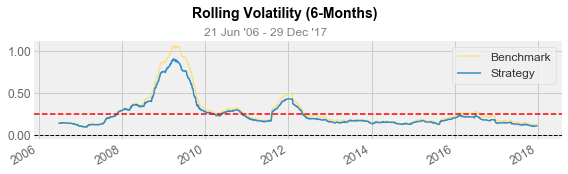

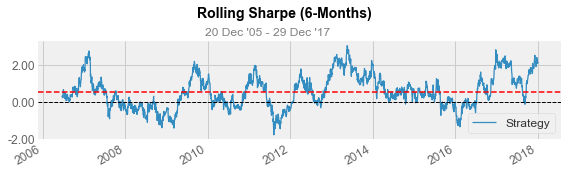

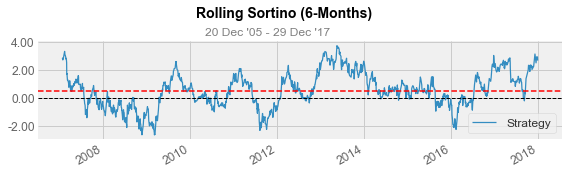

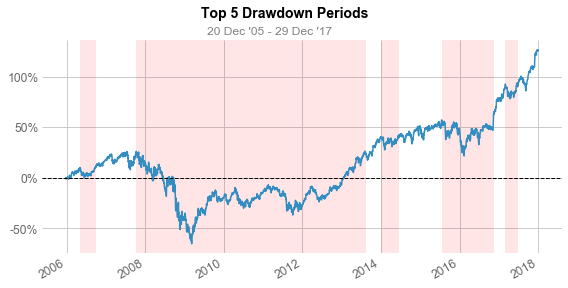

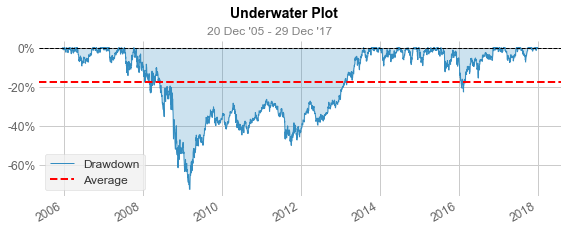

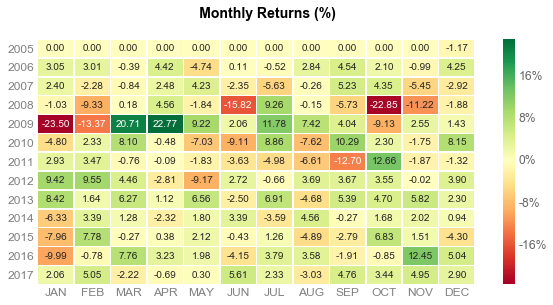

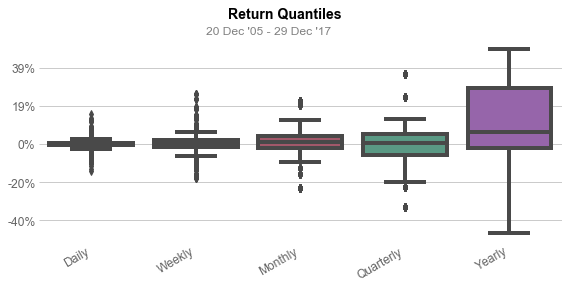

In [10]:
qs.reports.full(df_return['COSR_Returns'], df_return['EW_Returns'])

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2005-12-20  2005-12-20
End Period                 2017-12-29  2017-12-29
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          125.12%     158.78%
CAGR%                      6.98%       8.22%
Sharpe                     0.38        0.41
Sortino                    0.54        0.6
Max Drawdown               -72.39%     -62.53%
Longest DD Days            2122        1884
Volatility (ann.)          29.53%      31.65%
R^2                        0.78        0.78
Calmar                     0.1         0.13
Skew                       0.32        0.44
Kurtosis                   12.08       12.16

Expected Daily %           0.03%       0.03%
Expected Monthly %         0.56%       0.66%
Expected Yearly %          6.44%       7.59%
Kelly Criterion            3.17%       3.26%
Risk of Ruin               0.0%    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-10,2009-03-09,2013-08-01,2122,-72.392464,-65.443783
2,2015-07-20,2016-02-11,2016-11-10,479,-22.616432,-20.414937
3,2007-07-16,2007-08-15,2007-10-09,85,-14.227169,-13.366538
4,2014-01-02,2014-02-03,2014-06-06,155,-9.329843,-8.410261
5,2006-05-08,2006-06-14,2006-09-25,140,-9.317367,-8.811232


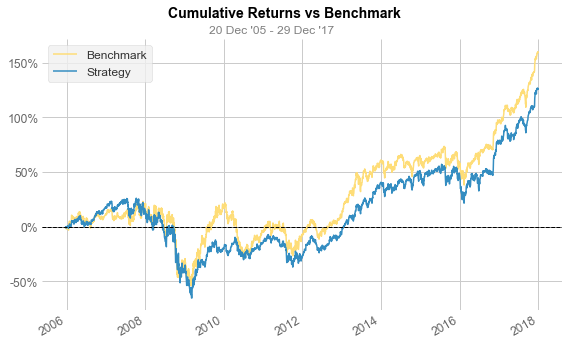

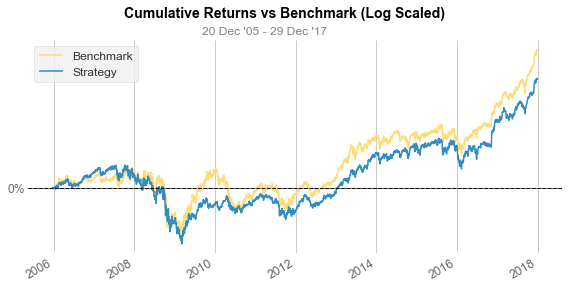

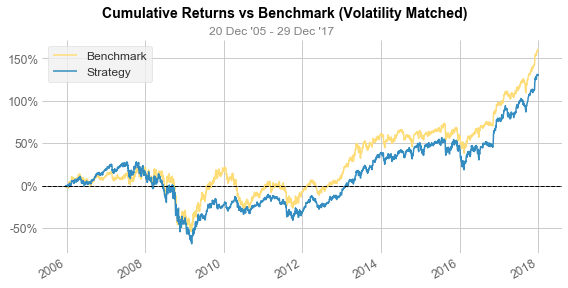

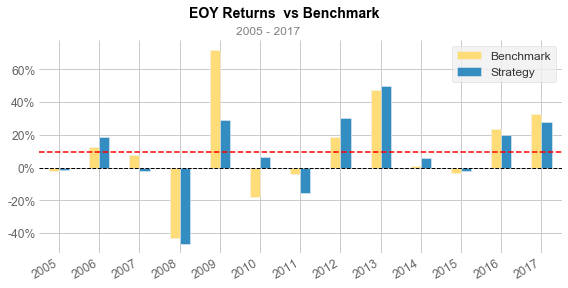

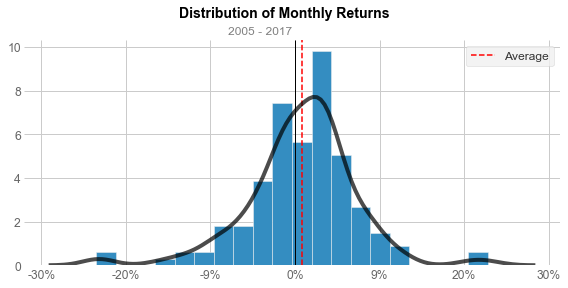

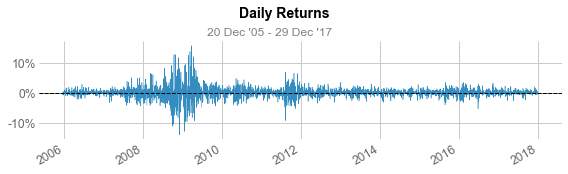

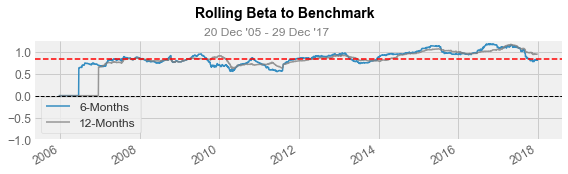

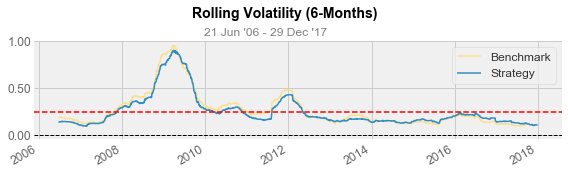

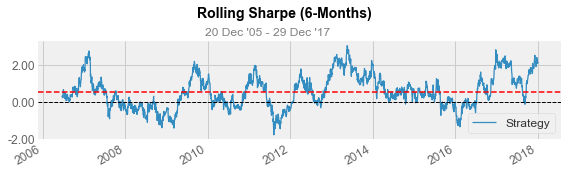

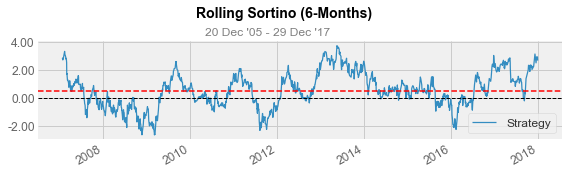

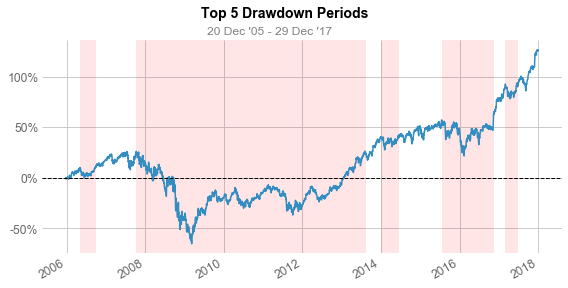

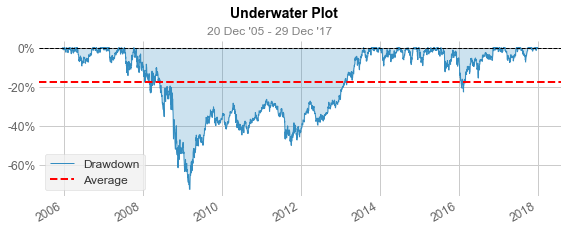

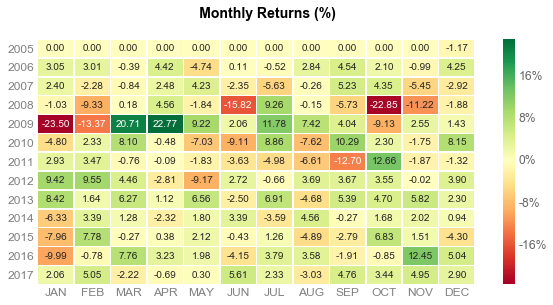

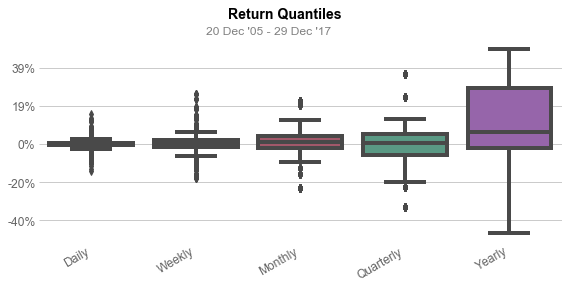

In [15]:
qs.reports.full(df_return['COSR_Returns'], df_return['SR_Returns'])